# **CC6204 - Deep Learning**

## **Predicción de riesgo de diabetes en etapas tempranas**

En esta tarea vas a desarrollar un modelo de aprendizaje que sea capaz de  determinar si una persona tiene riesgo de paceder diabetes en un futuro. Los datos han sido coleccionados a través de encuestas a pacientes en el Sylhet Diabetes Hospital en Bangladesh. Los datos han sido curados y verificados por profesionales de la salud, por lo que son confiables para crear un modelo de aprendizaje.

Primero vamos a importar los paquetes necesarios para trabajar en estos datos.

In [31]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style='darkgrid')

## **Descarga de archivo de datos**
Los datos están disponibles en un archivo CSV que contiene 520 muestras de 17 atributos. Los atributos son:

*   Age: numérico
*   Género: \[Male, Female\]
*   Polyuria
*   Polydipsia
*   sudden weight loss
*   weakness
*   Polyphagia
*   Genital thrush
*   visual blurring
*   Itching
*   Irritability 
*   delayed healing 
*   partial paresis 
*   muscle stiffness
*   Alopecia
*   Obesity
*   Class: \[Positive, Negative\]

Todos los atributos descritos sin valores tienen el conjunto \[Yes, No\]. 

En la siguiente celda de código, descargamos el archivo y lo leemos con Pandas. Finalmente, visualizamos algunos datos del conjunto.



In [32]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
dataset_path = 'diabetes_data_upload.csv'

--2022-08-27 18:28:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34682 (34K) [application/x-httpd-php]
Saving to: 'diabetes_data_upload.csv.3'

     0K .......... .......... .......... ...                  100% 31.1K=1.1s

2022-08-27 18:28:03 (31.1 KB/s) - 'diabetes_data_upload.csv.3' saved [34682/34682]



In [33]:
column_names = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss',
                'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring','Itching', 'Irritability', 'delayed healing',
                'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, header=1)

dataset = raw_dataset.copy()
dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
1,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
2,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
3,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
4,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive


# **Pre-procesamiento del conjunto de datos**
El conjunto de datos es variado. El atributo "Age" es el único atributo numérico. Todos los demás atributos son nominales. Para procesar los datos nominales en una red neuronal, es mejor convertirlos a una representación numérica. En el siguiente ejemplo transformamos el atributo "Gender" con valores nominales "Female" y "Male" a valores 1.0 y 0.0, respectivamente.

Del mismo modo, cambiamos los valores nominales de todos los atributos a valores 0.0 y 1.0.

In [34]:
gender = dataset.pop('Gender')
dataset['gender'] = (gender == 'Female')*1.0

column_class = dataset.pop('class')
dataset['class'] = (column_class=='Positive')*1.0

for column in column_names:
  if column not in ['Gender', 'class', 'Age']:
    column_class = dataset.pop(column)
    dataset[column] = (column_class=='Yes')*1.0

# Prueba mostrando parte de la data para ver si tu conversión se hizo correctamente
dataset.tail()


,Age,gender,class,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
514,39,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
515,48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
516,58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
517,32,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
518,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora normalizamos el atributo "Age" y dividimos la data en conjunto de entrenamiento y conjunto de test. Esta división es siempre necesaria para poder probar si tu modelo de aprendizaje ha aprendido a generalizar con datos que no pertenecen al conjunto de entrenamiento.

In [35]:
max_age = dataset["Age"].max()
dataset["Age"] = dataset["Age"] / max_age
dataset.tail()


#80% de datos para train y 20% de datos para test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('class')
test_labels = test_dataset.pop('class')


In [36]:
#Convertimos todo a arrays Numpy
X_train = train_dataset.to_numpy()
X_test = test_dataset.to_numpy()

Y_train = train_labels.to_numpy()
Y_test = test_labels.to_numpy()

Y_train = Y_train[:,None]
Y_test = Y_test[:,None]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(415, 16)
(415, 1)
(104, 16)
(104, 1)


# **Parte 1**
Diseña y entrena un perceptrón multicapa con la data de arriba. Intenta que tu modelo alcance el mayor accuracy de test posible (ojalá por encima del 93%). Para este primer experimento puedes usar la implementación de MLP vista en clase (basada en Numpy) ó puedes usar algún framework como Tensorflow o Pytorch si es que deseas. Hay que tener en cuenta algunas consideraciones para este primer experimento:



*   Usar gradiente descendiente estocástico con un tamaño de mini-batch de 20. 
*   Usar learning rate de 0.01.
*  Los mini-batches NO se generan de manera aleatoria.

Graficar la función de loss con respecto a las épocas.

In [37]:
#This class describes a fully connected layer (without activation function)

class Linear:
    # W: weight matrix (in x out)
    # b: bias (out x 1)
    
    #Constructor - we define the parameters of this layer
    def __init__(self, num_inputs, num_outputs, learning_rate, name):
      #The parameters are initialized randomly - uniform distribution [0,1)
      self.W = np.random.rand(num_inputs, num_outputs)
      self.b = np.zeros((num_outputs, 1))
      self.lr = learning_rate
      self.name = name
    
    # input: mini-batch (batch_size x in)
    # This function only operates the linear function
    def forward(self, input):
      self.inputs = input
      return np.dot(self.inputs, self.W) + self.b.T
    
    # dy: Error in next layer (batch_size x out)
    # This functions receives the error of the next layer and computes the error in this layer
    def backward(self, dy):
      batch_size = dy.shape[0]
      dy = dy.T # (out x batch_size)
      dw = dy.dot(self.inputs) #(out x in)
      db = np.sum(dy, axis=1, keepdims=True) #(out x 1)
      dx = np.dot(dy.T, self.W.T) # (batch_size x out) x (out x in)
       
      #SGD Rules
      self.W -= (self.lr/batch_size)*dw.T
      self.b -= (self.lr/batch_size)*db
        
      #The function computes the error in this layer and returns it for backpropagation
      return dx
    
#Class for the sigmoid activation function
class Sigmoid:
    def __init__(self):
      pass
    
    #Computes the sigmoid function
    def forward(self, inputs):
      self.output = 1/(1 + np.exp(-inputs))
      return self.output
    
    #Backpropagates the incoming error using the derivative of sigmoid
    def backward(self, dy):
      return dy*self.output*(1-self.output) # dy/4

#Loss function
def mse(output, labels):
  return 0.5*np.sum((output-labels)**2)

#Class for the neural network
class NetworkSigmoid:
    def __init__(self, lr=0.01):
      lr = lr #Learning rate
        
      #The layers are in a list
      # We create a three-layer network with sigmoid neurons
      self.layers = [] 
      self.layers.append(Linear(num_inputs=16, num_outputs=8, learning_rate=lr, name='fc1')) #10 + 5 = 15
      self.layers.append(Sigmoid())
      self.layers.append(Linear(num_inputs=8, num_outputs=8, learning_rate=lr, name='fc2')) #25 + 5 = 30     = Cost is a function 51-dimensional space
      self.layers.append(Sigmoid())
      self.layers.append(Linear(num_inputs=8, num_outputs=1, learning_rate=lr, name='fc2')) #5 + 1 = 6
      self.layers.append(Sigmoid())
      self.num_layers = len(self.layers)
    
    #Implements the training algorithm with mini-batch SGD
    def train(self, training_data, training_label, batch_size, epoch, test_data, test_label, verbose=False):
      #History values of losses
      train_loss = []
      test_loss = []
        
      #Main outer loop
      for e in range(epoch):
        # Perform a training epoch
        loss = 0
      
        #Iterate over each batch
        for batch_index in range(0, training_data.shape[0], batch_size):
          #We need to identify whether a batch is complete or a batch is incomplete because it is the last one 
          if batch_index+batch_size < training_data.shape[0]:
            data = training_data[batch_index:batch_index+batch_size]
            label = training_label[batch_index:batch_index+batch_size]
          else:
            data = training_data[batch_index:training_data.shape[0]]
            label = training_label[batch_index:training_label.shape[0]]
                                
          acc = 0
                
          #Forward pass - iterate over the list of layers
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          #The first error is the derivative of the loss wrt. the NN output          
          dy = output - label
          loss += mse(output, label) #Compute the loss

          #Backpropagate
          for l in range(self.num_layers-1, -1, -1):
            dout = self.layers[l].backward(dy)
            dy = dout
                    
        #End of an epoch
        loss /= training_data.shape[0]
        train_loss.append(loss)
                                  
        #Test after one epoch
        loss = 0
        outputs = []
            
        correct = 0
        for batch_index in range(0, test_data.shape[0], batch_size):
          if batch_index+batch_size < test_data.shape[0]:
            data = test_data[batch_index:batch_index+batch_size]
            label = test_label[batch_index:batch_index+batch_size]
          else:
            data = test_data[batch_index:test_data.shape[0]]
            label = test_label[batch_index:test_label.shape[0]]
                                
          acc = 0
                
          #Forward pass
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output
                
          loss += mse(output, label)
                
          test_output = (output >= 0.5)
          #Compare the output of the network with the correct labels
          correct += (test_output == label).sum()
            
        loss /= test_data.shape[0]
        test_loss.append(loss)
            
        if verbose:
          print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
        else:
          if e % 20 == 0:
            print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
                    
      return dict({'train_loss': train_loss, 'test_loss':test_loss})
    
    def evaluate(self, data, label, batch_size):
      correct = 0
      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
          nlabel = label[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
          nlabel = label[batch_index:label.shape[0]]
            
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
            
        test_output = (output >= 0.5)
        #Compare the output of the network with the correct labels
        correct += (test_output == nlabel).sum()
        
      return (100*correct)/label.shape[0]

    def predict(self, data, batch_size):
      output_pred = []

      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
                    
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
                    
        test_output = (output >= 0.5)
        #test_output = np.argmax(output, axis=1)
        output_pred.append(test_output)
      
      return np.vstack(output_pred)

Epoch 0/10000: loss = 0.1758681682431722: Test accuracy=61.53846153846154
Epoch 20/10000: loss = 0.16400359999990993: Test accuracy=61.53846153846154
Epoch 40/10000: loss = 0.13637328728261028: Test accuracy=61.53846153846154
Epoch 60/10000: loss = 0.11789065092805154: Test accuracy=61.53846153846154
Epoch 80/10000: loss = 0.11677257254802983: Test accuracy=61.53846153846154
Epoch 100/10000: loss = 0.11674039299601915: Test accuracy=61.53846153846154
Epoch 120/10000: loss = 0.11671240773889033: Test accuracy=61.53846153846154
Epoch 140/10000: loss = 0.11668171302951405: Test accuracy=61.53846153846154
Epoch 160/10000: loss = 0.11665031299151776: Test accuracy=61.53846153846154
Epoch 180/10000: loss = 0.11661851115827829: Test accuracy=61.53846153846154
Epoch 200/10000: loss = 0.11658633737714644: Test accuracy=61.53846153846154
Epoch 220/10000: loss = 0.11655378450892048: Test accuracy=61.53846153846154
Epoch 240/10000: loss = 0.11652084029600565: Test accuracy=61.53846153846154
Epoch 

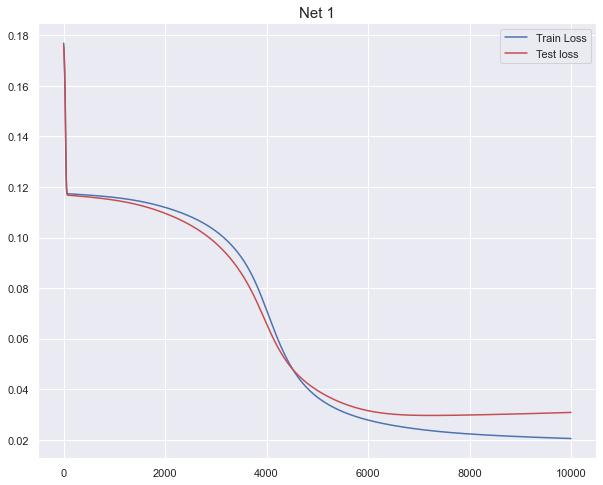

In [38]:
net = NetworkSigmoid()
history = net.train(X_train, Y_train, 20, 10000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))

plt.figure(figsize=(10,8))
plt.plot(history['train_loss'], color='b', label='Train Loss')
plt.plot(history['test_loss'], color='r', label='Test loss')
plt.title('Net 1',fontsize=15)
plt.legend()
plt.show()

# **Parte 2**
Intenta cambiar el tamaño de los mini-batches. Como casos extremos usa m=1 (mini-batches de tamaño 1) y m=n(1 solo mini-batch con todos los datos). Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

Epoch 0/10000: loss = 0.18688118575239476: Test accuracy=61.53846153846154
Epoch 20/10000: loss = 0.11525373311858264: Test accuracy=61.53846153846154
Epoch 40/10000: loss = 0.11422881664261918: Test accuracy=61.53846153846154
Epoch 60/10000: loss = 0.11294913510875586: Test accuracy=61.53846153846154
Epoch 80/10000: loss = 0.11125809861741809: Test accuracy=61.53846153846154
Epoch 100/10000: loss = 0.10893009690343239: Test accuracy=61.53846153846154
Epoch 120/10000: loss = 0.10562820786688162: Test accuracy=61.53846153846154
Epoch 140/10000: loss = 0.10069013730196041: Test accuracy=73.07692307692308
Epoch 160/10000: loss = 0.0923274248896235: Test accuracy=75.0
Epoch 180/10000: loss = 0.07654213652052093: Test accuracy=84.61538461538461
Epoch 200/10000: loss = 0.056489957013771325: Test accuracy=93.26923076923077
Epoch 220/10000: loss = 0.044939062573250005: Test accuracy=91.34615384615384
Epoch 240/10000: loss = 0.03900904077029558: Test accuracy=90.38461538461539
Epoch 260/10000: 

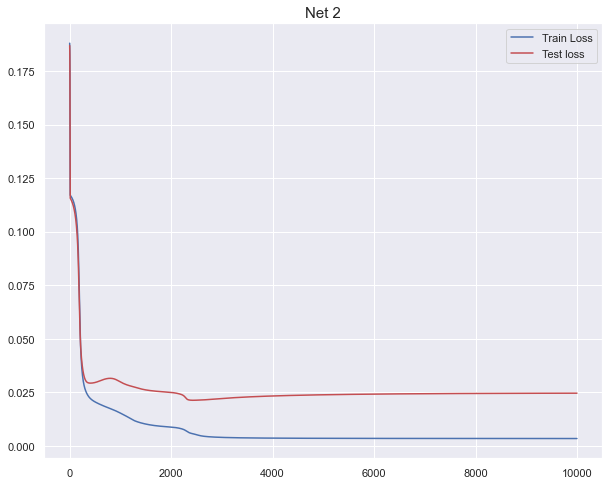

In [39]:
net2 = NetworkSigmoid()
history2 = net2.train(X_train, Y_train, 1, 10000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net2.evaluate(X_train, Y_train, 1), net2.evaluate(X_test, Y_test, 1)))

plt.figure(figsize=(10,8))
plt.plot(history2['train_loss'], color='b', label='Train Loss')
plt.plot(history2['test_loss'], color='r', label='Test loss')
plt.title('Net 2',fontsize=15)
plt.legend()
plt.show()

Epoch 0/10000: loss = 0.18265456032126653: Test accuracy=61.53846153846154
Epoch 20/10000: loss = 0.18252437864513: Test accuracy=61.53846153846154
Epoch 40/10000: loss = 0.18239085371729827: Test accuracy=61.53846153846154
Epoch 60/10000: loss = 0.1822538615980795: Test accuracy=61.53846153846154
Epoch 80/10000: loss = 0.1821132724405708: Test accuracy=61.53846153846154
Epoch 100/10000: loss = 0.18196895015248402: Test accuracy=61.53846153846154
Epoch 120/10000: loss = 0.18182075203586395: Test accuracy=61.53846153846154
Epoch 140/10000: loss = 0.1816685284031269: Test accuracy=61.53846153846154
Epoch 160/10000: loss = 0.18151212216773305: Test accuracy=61.53846153846154
Epoch 180/10000: loss = 0.1813513684076871: Test accuracy=61.53846153846154
Epoch 200/10000: loss = 0.1811860938999313: Test accuracy=61.53846153846154
Epoch 220/10000: loss = 0.18101611662356185: Test accuracy=61.53846153846154
Epoch 240/10000: loss = 0.1808412452296542: Test accuracy=61.53846153846154
Epoch 260/1000

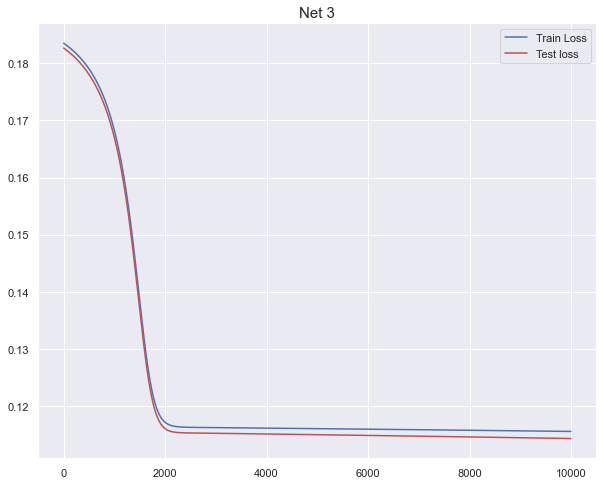

In [40]:
net3 = NetworkSigmoid()
history3 = net3.train(X_train, Y_train, 415, 10000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net3.evaluate(X_train, Y_train, 415), net3.evaluate(X_test, Y_test, 104)))

plt.figure(figsize=(10,8))
plt.plot(history3['train_loss'], color='b', label='Train Loss')
plt.plot(history3['test_loss'], color='r', label='Test loss')
plt.title('Net 3',fontsize=15)
plt.legend()
plt.show()

# **Parte 3**
Intenta cambiar el learning rate. Como casos extremos usa lr = 0.5 y lr = 0.000001. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

Epoch 0/10000: loss = 0.13443764740335842: Test accuracy=61.53846153846154
Epoch 20/10000: loss = 0.11410101038175122: Test accuracy=61.53846153846154
Epoch 40/10000: loss = 0.10835045168381198: Test accuracy=61.53846153846154
Epoch 60/10000: loss = 0.0876781905309121: Test accuracy=77.88461538461539
Epoch 80/10000: loss = 0.04505083066645278: Test accuracy=91.34615384615384
Epoch 100/10000: loss = 0.031162665616762432: Test accuracy=91.34615384615384
Epoch 120/10000: loss = 0.029319392725707976: Test accuracy=90.38461538461539
Epoch 140/10000: loss = 0.03042206736826954: Test accuracy=91.34615384615384
Epoch 160/10000: loss = 0.03096334762759373: Test accuracy=92.3076923076923
Epoch 180/10000: loss = 0.03154350237916997: Test accuracy=92.3076923076923
Epoch 200/10000: loss = 0.03223742760271389: Test accuracy=92.3076923076923
Epoch 220/10000: loss = 0.03294421568099546: Test accuracy=93.26923076923077
Epoch 240/10000: loss = 0.033559585754503934: Test accuracy=92.3076923076923
Epoch 2

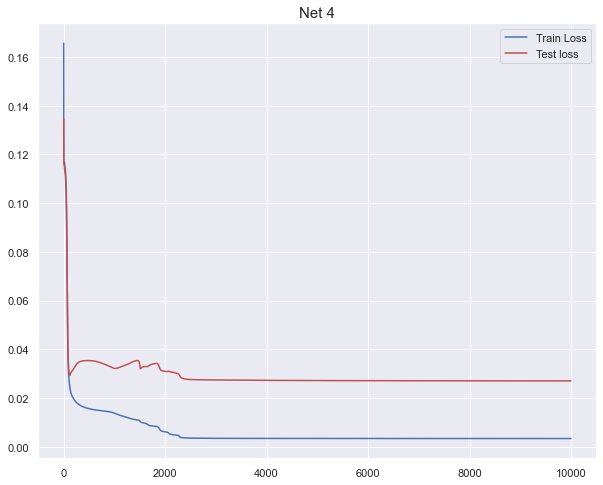

In [41]:
net4 = NetworkSigmoid(lr=0.5)
history4 = net4.train(X_train, Y_train, 20, 10000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net4.evaluate(X_train, Y_train, 20), net4.evaluate(X_test, Y_test, 20)))

plt.figure(figsize=(10,8))
plt.plot(history4['train_loss'], color='b', label='Train Loss')
plt.plot(history4['test_loss'], color='r', label='Test loss')
plt.title('Net 4',fontsize=15)
plt.legend()
plt.show()

Epoch 0/10000: loss = 0.18345614249737321: Test accuracy=61.53846153846154
Epoch 20/10000: loss = 0.18345591395551086: Test accuracy=61.53846153846154
Epoch 40/10000: loss = 0.18345568540247045: Test accuracy=61.53846153846154
Epoch 60/10000: loss = 0.18345545683825115: Test accuracy=61.53846153846154
Epoch 80/10000: loss = 0.18345522826285224: Test accuracy=61.53846153846154
Epoch 100/10000: loss = 0.18345499967627282: Test accuracy=61.53846153846154
Epoch 120/10000: loss = 0.18345477107851227: Test accuracy=61.53846153846154
Epoch 140/10000: loss = 0.18345454246956963: Test accuracy=61.53846153846154
Epoch 160/10000: loss = 0.18345431384944416: Test accuracy=61.53846153846154
Epoch 180/10000: loss = 0.18345408521813517: Test accuracy=61.53846153846154
Epoch 200/10000: loss = 0.18345385657564175: Test accuracy=61.53846153846154
Epoch 220/10000: loss = 0.18345362792196324: Test accuracy=61.53846153846154
Epoch 240/10000: loss = 0.18345339925709875: Test accuracy=61.53846153846154
Epoch

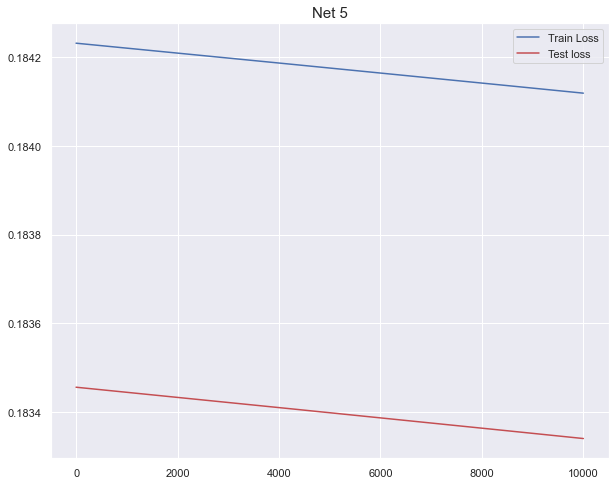

In [42]:
net5 = NetworkSigmoid(lr=0.000001)
history5 = net5.train(X_train, Y_train, 20, 10000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net5.evaluate(X_train, Y_train, 20), net5.evaluate(X_test, Y_test, 20)))

plt.figure(figsize=(10,8))
plt.plot(history5['train_loss'], color='b', label='Train Loss')
plt.plot(history5['test_loss'], color='r', label='Test loss')
plt.title('Net 5',fontsize=15)
plt.legend()
plt.show()

# **Parte 4**
Implementar el algoritmo de gradiente descendente estocástico de manera que los mini-batches se generen de manera aleatoria antes de cada época. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.